# Linear Regression

This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur and updated by Ross Beveridge.

Last Update 10/12/2021

**The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import default_rng

## Part 1: Regression Basics

*Adapted from Chapter 3 of [An Introduction to Statistical Learning](https://www.statlearning.com)*

### Regression problems

The two primary types of machine learning problems we will focus on in this course are:

* **Classification problems:** supervised learning problems with a categorical response
* **Regression problems**: supervised learning problems with a continuous response

In this notebook we will learn one of the simplest methods for regression, namely **Linear regression**.

Why learn linear regression?

- Fast
- Easy to use
- Interpretable
- Basis for many other methods


## Part 2: The Advertising Data

To illustrate the concept of linear regression we will use a dataset that describes product sales as a function of advertising.

What are the examples?

- Each example represents a product in a given market with a total of 200 in the dataset.

What are the features?

- **TV:** advertising dollars spent on TV ads 
- **radio:** advertising dollars spent on radio ads
- **newspaper:** advertising dollars spent on newspaper ads

All expenditures are in **thousands** of dollars.

What are the labels?

- **sales:** sales of a product in a given market (in thousands of widgets)


**Note on Getting Data**

The link to the original csv file on Gareth James' homepage is no longer active.  Student in CS 345 can obtain a local copy following the links on our Canvas course page. Please do not redistribut this data.  Once you get the file, place it in a `datasets` subfolder and proceed running this worksheet. You can also use this shortcut: [Advertising.csv](https://drive.google.com/file/d/1Vx_Wi-hddEHT7_XqZ5JGylTV5Q0YBXDn/view?usp=sharing)

In [20]:
# read data into a pandas DataFrame
import pandas as pd
data = pd.read_csv('datasets/Advertising.csv', index_col=0)
data.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [21]:
data

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9
...,...,...,...,...
196,38.2,3.7,13.8,7.6
197,94.2,4.9,8.1,9.7
198,177.0,9.3,6.4,12.8
199,283.6,42.0,66.2,25.5


### How can you help?

You are asked by the company: On the basis of this data, how should we spend our advertising money?

As their machine learning / data scientist, you offer more specific help:

* Is there a relationship between ads and sales?
* How strong is that relationship?
* Which ad types contribute to sales?
* What is the effect of each ad type on sales?
* Given ad spending in a particular market, can sales be predicted?


## Part 3: Visualizing the data

We'll use a **scatter plot** to visualize the relationship between the features and the labels. But first, a detail, here is an example of `iloc` used to access a single sample in the data frame.

In [22]:
data.iloc[0]

TV           230.1
Radio         37.8
Newspaper     69.2
Sales         22.1
Name: 1, dtype: float64

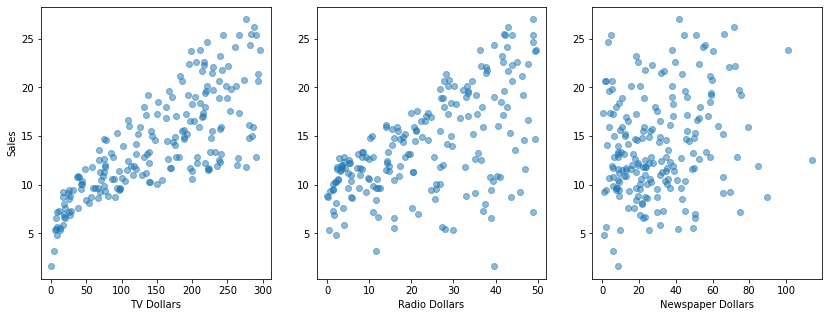

In [23]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(14, 5))
ax1.scatter(data['TV'], data['Sales'], alpha=0.5)
ax1.set_xlabel('TV Dollars')
ax1.set_ylabel('Sales')
ax2.scatter(data['Radio'], data['Sales'], alpha=0.5)
ax2.set_xlabel('Radio Dollars')
ax3.scatter(data['Newspaper'], data['Sales'], alpha=0.5)
ax3.set_xlabel('Newspaper Dollars');

We can quantify the relationships between variables by computing the correlation matrix. Keep in mind we are jumping over a lot of background and motivation which we will return to later. To learn more about just the functionality we are tapping into see [pandas.DataFrame.corr](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html)

## Part 4: Correlating Advertising to Sales

Linear regrression is intimately related to the underlying concept of correlation. 

In simple English, how much does a dollar spent on advertising (e.g. TV) relate to an increase (or worst case a decrease) in widget sales?

There are actually at least two very different parts to this question. 

The first involves **"noise"** and you can already see more "noise" in the Newspaper plot compared to the TV plot.

The second involves the and actual expect rate of increased sales. This will come shortly as we begin fitting regression lines.

For now, let us look at correlation more closely.

In [24]:
# compute the correlation matrix
data.corr()

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.782224
Radio,0.054809,1.000000,0.354104,0.576223
Newspaper,0.056648,0.354104,1.000000,0.228299
Sales,0.782224,0.576223,0.228299,1.000000


Correlation is a quantification of the strength of the **linear** relationship between two variables.  

We observe that the amount spent on TV ads is the most strongly correlated variable (predictive) relative to sales.

Let's construct a model that predicts sales from TV ads alone.  First extract the necessary data:

In [25]:
# create feature matrix and vector of labels
X = data[['TV']].values
y = data['Sales'].values
X.shape, y.shape

((200, 1), (200,))

In [8]:
np.corrcoef(X[:,0],y)

array([[1.        , 0.78222442],
       [0.78222442, 1.        ]])

## Deeper Dive into Correlation

What is really going on here?  

We can take this cacluation apart one more level and actually relate the correlation value to something we already understand - normalized vectors and dot products.  You may want to quickly glance at Wikipedia page on correlation as we jump in here. 

Working from the wikipedia page and adopting its notation, here is an equation that captures the formal definition of the sample correlation coefficient between two variables:

$$
r_{xy} = \frac{\sum_{i=1}^{n}{(x_i} - \hat{x})(y_i - \hat{y})}
            {\sqrt{\sum_{i=1}^{n}{(x_i - \hat{x})^2}\sum_{i=1}^{n}{(y_i - \hat{y})^2}}}
$$

But wait, here comes the very cool trick.  

Look closely at the numerator.  What you see is the average of each vector $\hat{x}$ is being subtracted from each sample.  What would happen if $\hat{x}$ and $\hat{y}$ were both zero?  The numerator would reduce to:

$$
\sum_{i=1}^{n}{x^{\prime}_i y^{\prime}_i} = X^{\prime} \cdot Y^{\prime} 
       \;\;\; X^{\prime} = X - \hat{x} \;\;\; Y^{\prime} = Y - \hat{y}
$$

In words, just the dot product between the vectors X and Y. Now in general the mean will not equal zero, but it is very easy to make a small adjustment such that the mean becomes zero. Just subtract the mean to produce a new vector like the first but with zero mean.

Now look at the demoninator.  

$$
\sqrt{\sum_{i=1}^{n}{(x_i - \hat{x})^2}\sum_{i=1}^{n}{(y_i - \hat{y})^2}}
$$

What you see is the product of the sample standard deviation for the X and Y vectors.  Image just for the moment that the sample standard deviation of the vectors just happened to be one. In that case, the entire denominator equals one and for that special case:

$$
r_{xy} = X^{\prime\prime} \cdot Y^{\prime\prime} \;\;\;\;\;\;
X^{\prime\prime} = \frac{X^{\prime}}{\sqrt{\sum_{i=1}^{n}{(x^{\prime}_i)^2}}}  \;\;\;\;
Y^{\prime\prime} = \frac{Y^{\prime}}{\sqrt{\sum_{i=1}^{n}{(y^{\prime}_i)^2}}} 
$$

Look closely at the way $X^{\prime\prime}$ is being defined.  The denominator is simply the length (magnitude) of the vector $X^{\prime}$. 

Let us wrap this up with a summary of what we have done and then show how it works using the correlation calcuation already carried out by our tool package above.  To compute the correlation between two vectors following the following steps. First subract off the average (mean) value from each; $X^{\prime}$ and $Y^{\prime}$ above. Second, divde through each by the sample standard deviation; $X^{\prime\prime}$ and $Y^{\prime\prime}$ above. Third and last, take the dot product of the two resulting vectors.

In [9]:
Vector_A = X[:,0]
Vector_B = y
Vector_A_zm = Vector_A - np.mean(Vector_A)
Vector_B_zm = Vector_B - np.mean(Vector_B)
Vector_A_hat = Vector_A_zm / np.linalg.norm(Vector_A_zm)
Vector_B_hat = Vector_B_zm / np.linalg.norm(Vector_B_zm)
Vector_A_hat @ Vector_B_hat

0.7822244248616064

## Part 5: Linear Regression for TV to Sales

So far you have a good understanding of how to measure the correlation between to sets of values captured in vectors $X$ and $Y$.  

The sklearn library has an excellent prebuilt package for carrying out linear regression accross multiple independent variables. We will use tool to predict sales based upon where and how advertising dollars are spent.


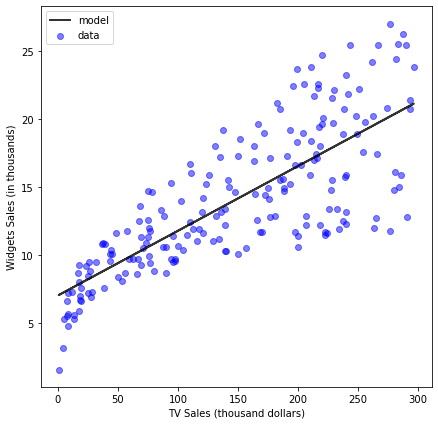

In [10]:
from sklearn.linear_model import LinearRegression

# instantiate, fit, and predict:
linreg = LinearRegression()
linreg.fit(X, y)
y_pred = linreg.predict(X)

# plot the reslts
fig = plt.figure(figsize=(7,7))
ax  = fig.add_subplot(111)

ax.scatter(X, y,  color='blue', alpha=0.5, label = 'data')
ax.plot(X, y_pred, color='black', alpha=0.8,linewidth=2, label = 'model')
ax.set_xlabel('TV Sales (thousand dollars)')
ax.set_ylabel('Widgets Sales (in thousands)')
ax.legend(loc="best")

### What is Linear Regression giving us?

In one dimension, linear regression takes the following form:

$$
\large
y =  wx + b
$$

where:

- $y$ is the sample value (label)
- $x$ is the feature
- $b$ is the bias, or intercept in this case
- $w$ is the parameter corresponding to x

$w$ and $b$ are the **model parameters**, which are learned during the training process.  

The resulting model can then be used to predict the label, which in the context of regression, is also called the *response*.

Note this example makes use of the sklearn [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object


### Explicitly Plot Prediction Line

What about the TV Advertising (x) to Sales (y) analysis just run?

Regression is giving us the best fit (more on fitting soon) line such that:

$$
\large
y =  wx + b
$$

The regression coefficient $w$ which corresponds to the TV feature has the following interpretation:

- A unit increase in TV ad spending is associated with an increase of $w$ units in sales.
- This is not a statement of **causation**.

If an increase in TV ad spending was associated with a **decrease** in sales, $w$ would be **negative**.

Now let us retrieve the model parameters explicitly calculate the linear regression line.

We will show one example of how to put a change in predicitons into a simple English sentence and again plot the regression line. Note the regression line matches exactly what was shown above - as it should.


The w model parameter is 0.048
The b model parameter is 7.033
Increasing TV sales from 100 to 200 increases predicted sales from 11.8 to 16.5


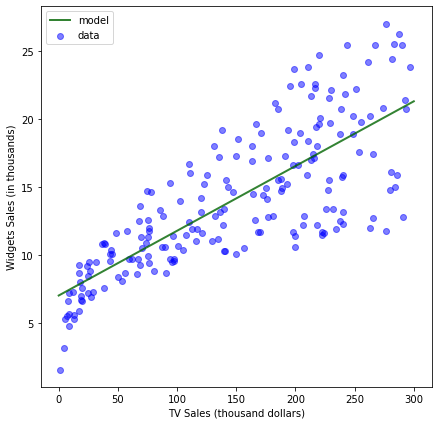

In [26]:
# Go get the model parameters
mp_w = linreg.coef_[0]
mp_b = linreg.intercept_

# Pring a short summary of parameters and example of prediction
print(f'The w model parameter is {mp_w:.3f}')
print(f'The b model parameter is {mp_b:.3f}')

wsat_100 = mp_w * 100 + mp_b
wsat_200 = mp_w * 200 + mp_b
print(f'Increasing TV sales from 100 to 200 increases predicted sales from {wsat_100:.1f} to {wsat_200:.1f}')

# Construct for a range of TV Sales values (x) the associated Widget sales (y)
xs = np.linspace(0,300,num=100)
ys = mp_w * xs + mp_b

# plot the reslts
fig = plt.figure(figsize=(7,7))
ax  = fig.add_subplot(111)

ax.scatter(X, y,  color='blue', alpha=0.5, label = 'data')
ax.plot(xs, ys, color='darkgreen', alpha=0.8,linewidth=2, label = 'model')
ax.set_xlabel('TV Sales (thousand dollars)')
ax.set_ylabel('Widgets Sales (in thousands)')
ax.legend(loc="best")

## Part 6: Fitting Revealed

Note we've already grown used to the term "fit" as describing the process of building a model from training data.  This actually was a bit strange for nearest neighbor.  Now we see how very literally the model is fit to the data. N

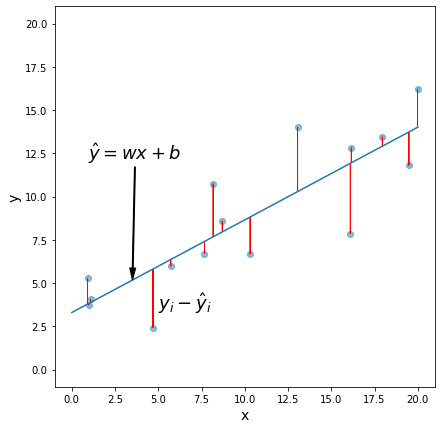

In [12]:
def regression_revealed(seed=5,equation=True) :
    from numpy.random import default_rng
    rng = default_rng(seed)
    nsamples = 15
    xmax = 20
    slope = 0.5
    intersept = 5
    sigma = 3
    x = xmax * rng.random(nsamples)
    y = slope * x + intersept + rng.standard_normal(nsamples) * sigma
    #x = 10 * rng.random(15)
    #y = 2 * x - 5 + rng.standard_normal(15)* 5

    # instantiate and fit
    model = LinearRegression()
    model.fit(x[:, np.newaxis], y)

    # data for plotting the regression line
    xs = np.linspace(0, xmax, 1000)
    ys = model.predict(xs[:, np.newaxis])

    # plot the regression line
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.scatter(x, y, alpha=0.5)
    ax.plot(xs, ys)
    ax.set_xlabel('x', fontsize = 14)
    ax.set_ylabel('y', fontsize = 14)
    ax.set_xlim(-1, xmax+1)
    ax.set_ylim(-1, xmax+1)
    
    # the predictions over the training data
    y_hat = model.predict(x[:, np.newaxis])

    for i in range(len(x)):
        ax.arrow(x[i],y_hat[i], 0, y[i]-y_hat[i],color='red')  
    if equation :
        lnpos = 175
        ax.text(5, 3.5, r'$y_i-\hat{y}_i$', fontsize = 18);
        ax.annotate(r'$\hat{y} = wx + b$', fontsize=18, xy=(xs[lnpos], ys[lnpos]), 
                     xytext=(xs[lnpos]-2.55, ys[lnpos]+7),
                     arrowprops=dict(facecolor='black',width=1,headwidth=6));
    return None

regression_revealed()

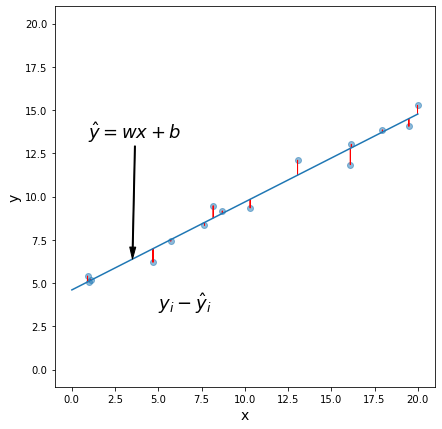

In [32]:
def regression_revealed_2(seed=5,equation=True) :
    from numpy.random import default_rng
    rng = default_rng(seed)
    nsamples = 15
    xmax = 20
    slope = 0.5
    intersept = 5
    sigma = 0.7
    x = xmax * rng.random(nsamples)
    y = slope * x + intersept + rng.standard_normal(nsamples) * sigma
    #x = 10 * rng.random(15)
    #y = 2 * x - 5 + rng.standard_normal(15)* 5

    # instantiate and fit
    model = LinearRegression()
    model.fit(x[:, np.newaxis], y)

    # data for plotting the regression line
    xs = np.linspace(0, xmax, 1000)
    ys = model.predict(xs[:, np.newaxis])

    # plot the regression line
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.scatter(x, y, alpha=0.5)
    ax.plot(xs, ys)
    ax.set_xlabel('x', fontsize = 14)
    ax.set_ylabel('y', fontsize = 14)
    ax.set_xlim(-1, xmax+1)
    ax.set_ylim(-1, xmax+1)
    
    # the predictions over the training data
    y_hat = model.predict(x[:, np.newaxis])

    for i in range(len(x)):
        ax.arrow(x[i],y_hat[i], 0, y[i]-y_hat[i],color='red')  
    if equation :
        lnpos = 175
        ax.text(5, 3.5, r'$y_i-\hat{y}_i$', fontsize = 18);
        ax.annotate(r'$\hat{y} = wx + b$', fontsize=18, xy=(xs[lnpos], ys[lnpos]), 
                     xytext=(xs[lnpos]-2.55, ys[lnpos]+7),
                     arrowprops=dict(facecolor='black',width=1,headwidth=6));
    return None

regression_revealed_2()

### Learning the model 

- Coefficients are estimated during the model fitting process using the **least squares criterion**.
- We seek to find the line that minimizes the **sum of squared error** illustrated in the figure above.

In this figure:

- The dots are the **observed values** of x and y.
- The blue line is the **least squares line**.
- The red lines are the **residuals**, which are the distances between the observed values and the least squares line.

How do the model parameters relate to the least squares line?

- $w$ is the **slope**
- $b$ is the **intercept** (the value of $y$ when $x$=0)

The parameters $(w,b)$ are chosen as to minimize the sum-squared error:
$$
J( w,b ) = \sum_{i=1}^N (y_i - \hat{y}_i)^2,
$$

where $y_i$ are the known labels and $\hat{y}_i = w x_i + b$ are the predicted labels.

### Mass Spring Metaphor

There is a useful and common metaphor from Physics to motivate least squares fitting in general and linear regression in this particular case. In the following figure now think of each red line as representing a spring.  Each spring is pulling the line up or down proportional to how much the string is streched. The least energy state for the line is that which minimizes the sum of squared lengths of the springs, and note that is equivalent to the mathematical formulation above.  In other words, if you like, you may think of the regression line as the solution to a physical problem - where does the line end up after it comes to rest and is minimizing all the push/pull forces assocated with the sample data points.

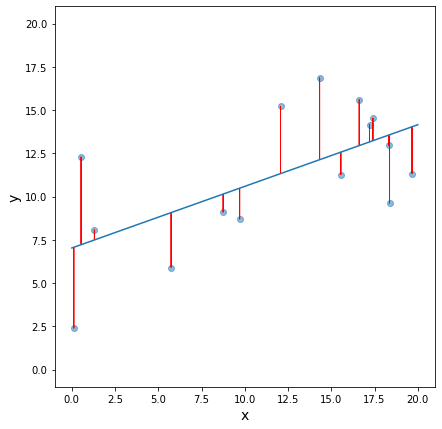

In [28]:
regression_revealed(seed=9,equation=False)

### and because one must ...

Correlation is a very big intellectual deal and is a jumping off point for a lot of thought and sometimes argument.  As just a teaser, consider the XKCD take on [Correlation](https://xkcd.com/552/)